In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os 
from scipy.stats import binom_test
from sequencing_tools.stats_tools import p_adjust
from scipy.stats import beta
from scipy.special import betaln
from functools import partial
from repeats_utils import *
from plotting_utils import spring_layout
from math import log
from plotting_utils import figure_path
#import adjustText
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)

In [2]:
count_table = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv'
df = pd.read_table(count_table)
df.head()

,gene_id,gene_name,gene_type,grouped_type,IGG-cf_R1_001:all:antisense,IGG-cf_R1_001:all:sense,IGG-cf_R1_001:dedup:antisense,IGG-cf_R1_001:dedup:sense,MPCEV_R1_001:all:antisense,MPCEV_R1_001:all:sense,...,S96-cfD_R1_001:dedup:antisense,S96-cfD_R1_001:dedup:sense,S96-cf_R1_001:all:antisense,S96-cf_R1_001:all:sense,S96-cf_R1_001:dedup:antisense,S96-cf_R1_001:dedup:sense,genome-sim_R1_001:all:antisense,genome-sim_R1_001:all:sense,genome-sim_R1_001:dedup:antisense,genome-sim_R1_001:dedup:sense
0,.,.,No features,No features,11158,11158,9269,9269,1384,1384,...,34118,34118,70777,70777,48629,48629,12346621,12346621,12340593,12340593
1,18S_rRNA,18S_rRNA,18S_rRNA,rRNA,889,780,583,491,129,6748,...,650,54222,1684,105674,1138,56461,211,236,211,233
2,28S_rRNA,28S_rRNA,28S_rRNA,rRNA,1172,1527,741,990,363,10419,...,1248,144037,2675,284094,1772,149656,475,510,454,461
3,5.8S_rRNA,5.8S_rRNA,5.8S_rRNA,rRNA,0,422,0,173,5,10511,...,45,91810,90,382151,48,94217,21,20,21,20
4,5S_rRNA,5S_rRNA,5S_rRNA,rRNA,0,8,0,5,4,5481,...,3,1362,3,2633,3,1403,1260,1182,477,231


(3.3298970532903622, 3.3107343379889396, 0, 1)


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


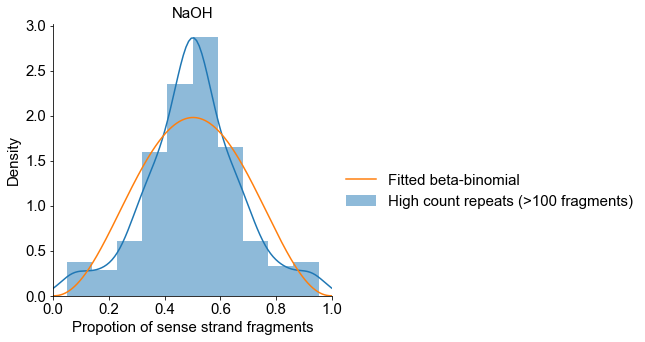

In [3]:
fig = plt.figure(figsize=(5,5))
#ax = fig.add_subplot(121)
sample_regex = 'Q[cC][fF][0-9]+'
#sample_regex = '[aA][lL][lL]'
p_df = get_repeat_df(df, sample_regex = sample_regex)


ax = fig.add_subplot(111)
sample_regex = 'Q[cC][fF]_[Nn][aA]'
naoh_p_df = get_repeat_df(df, sample_regex = sample_regex)
naoh_alpha0, naoh_beta0 = model_df(naoh_p_df, ax, title= 'NaOH')
ax.legend(bbox_to_anchor = (1,0.5), fontsize=15, frameon=False)

Text(22.125,0.5,'Posterior sense strand proportion')

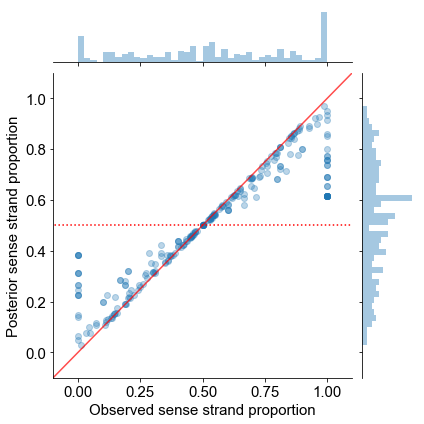

In [4]:
dnase_posterior_df = update_empirical_bayesr(p_df, naoh_alpha0, naoh_beta0)
naoh_posterior_df = update_empirical_bayesr(naoh_p_df, naoh_alpha0, naoh_beta0)

p = sns.JointGrid(data = dnase_posterior_df,  x= 'average',y='eb_estimate')
p.plot_joint(plt.scatter, alpha=0.3)
p.plot_marginals(sns.distplot, kde=False, bins=40)
ax = p.ax_joint
ax.hlines(xmin=-10,xmax=10, 
          y=naoh_alpha0/(naoh_alpha0+naoh_beta0), color='r', linestyle=':')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()])
]
ax.plot(lims, lims, 'r-', alpha=.7)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xlabel('Observed sense strand proportion')
ax.set_ylabel('Posterior sense strand proportion')
#sns.despine()

In [5]:
posterior_df = pd.concat([dnase_posterior_df.assign(treatment = 'DNase'),
         naoh_posterior_df.assign(treatment='NaOH')]) \
    .pipe(pd.melt, id_vars = ['treatment','gene_name','gene_id']) \
    .assign(variable = lambda d: d.treatment + ': ' + d.variable) \
    .pipe(pd.pivot_table, index=['gene_name', 'gene_id'],
         columns = 'variable', values = 'value') \
    .pipe(lambda d: fill_prior(d, (naoh_alpha0, naoh_beta0)))\
    .reset_index() \
    .fillna(0)\
    .pipe(lambda d: calulate_probability(d))  \
    .assign(delta_sense = lambda d: d['DNase: eb_estimate'] - d['NaOH: eb_estimate'])
posterior_df.sort_values('log_bf', ascending=False).head(20)
posterior_df.head()

variable,gene_name,gene_id,DNase: alpha1,DNase: antisense,DNase: average,DNase: beta1,DNase: eb_estimate,DNase: sense,NaOH: alpha1,NaOH: antisense,NaOH: average,NaOH: beta1,NaOH: eb_estimate,NaOH: sense,log_bf,pval,qval,delta_sense
1,Satellite:(GAATG)n,Satellite,8772.329897,3982.0,0.687711,3985.310734,0.687614,8769.0,126323.329897,189531.0,0.399935,189534.310734,0.399938,126320.0,9984.929119,0.0,0.0,0.287676
229,Simple_repeats:(GGA)n,Simple_repeats,816.329897,1117.0,0.421244,1120.310734,0.421519,813.0,593.329897,7407.0,0.073778,7410.310734,0.074133,590.0,1936.850380,0.0,0.0,0.347386
221,Simple_repeats:(GAGTG)n,Simple_repeats,2219.329897,345.0,0.865287,348.310734,0.864346,2216.0,11249.329897,13102.0,0.461886,13105.310734,0.461897,11246.0,1845.986114,0.0,0.0,0.402449
172,Simple_repeats:(CGG)n,Simple_repeats,1537.329897,281.0,0.845179,284.310734,0.843926,1534.0,790.329897,1395.0,0.360678,1398.310734,0.361105,787.0,1291.771409,0.0,0.0,0.482821
215,Simple_repeats:(GAA)n,Simple_repeats,1327.329897,1584.0,0.455296,1587.310734,0.455401,1324.0,728.329897,5263.0,0.121075,5266.310734,0.121497,725.0,2589.736303,0.0,0.0,0.333904


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


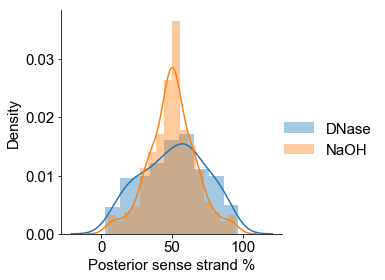

In [6]:
p = sns.FacetGrid(data =pd.concat([dnase_posterior_df.assign(treatment = 'DNase'),
                            naoh_posterior_df.assign(treatment='NaOH')])\
                      .assign(eb_estimate = lambda d: d.eb_estimate * 100), 
              hue = 'treatment',
              size = 4)
p.map(sns.distplot, 'eb_estimate')
p.set_axis_labels('Posterior sense strand %',
                'Density')
p.add_legend(title='', fontsize=15)

In [7]:
#https://repository.upenn.edu/cgi/viewcontent.cgi?article=3272&context=edissertations
telo = 'TAACCC|CCCGAA|CCCCAA|CCCTAG|TTAGGC|TTAGGG'
telo += '|' + reverse_complement(telo)
x_val = 'delta_sense'
y_val = 'log_bf'
plot_bf_df = posterior_df\
    .query('log_bf  > 0') \
    .assign(label = lambda d: np.where(d[x_val] < 0, 'Antisense','Sense')) \
    .assign(color = lambda d: 'gray')\
    .assign(color = lambda d: np.where(d.log_bf > 500, 'red', 
                                       np.where(d.log_bf > 2, 'darkred', d.color)))\
    .sort_values('log_bf', ascending=False)
plot_bf_df.head()

variable,gene_name,gene_id,DNase: alpha1,DNase: antisense,DNase: average,DNase: beta1,DNase: eb_estimate,DNase: sense,NaOH: alpha1,NaOH: antisense,NaOH: average,NaOH: beta1,NaOH: eb_estimate,NaOH: sense,log_bf,pval,qval,delta_sense,label,color
3,Satellite:ALR/Alpha,centr,9962.329897,8956.0,0.526513,8959.310734,0.526505,9959.0,1.852780e+06,1628532.0,0.532207,1.628535e+06,0.532207,1852777.0,13085.500478,0.941956,92.552139,-0.005702,Antisense,red
1,Satellite:(GAATG)n,Satellite,8772.329897,3982.0,0.687711,3985.310734,0.687614,8769.0,1.263233e+05,189531.0,0.399935,1.895343e+05,0.399938,126320.0,9984.929119,0.000000,0.000000,0.287676,Sense,red
0,Satellite:(CATTC)n,Satellite,4573.329897,8086.0,0.361094,8089.310734,0.361167,4570.0,2.247913e+05,152350.0,0.596036,1.523533e+05,0.596035,224788.0,9647.152469,1.000000,159.015275,-0.234868,Antisense,red
14,Satellite:HSATII,Satellite,2930.329897,2515.0,0.537854,2518.310734,0.537809,2927.0,4.888513e+05,304671.0,0.616051,3.046743e+05,0.616050,488848.0,3824.908599,1.000000,158.015275,-0.078240,Antisense,red
303,Simple_repeats:(TTC)n,Simple_repeats,1587.329897,1324.0,0.544704,1327.310734,0.544606,1584.0,5.266330e+03,725.0,0.878925,7.283107e+02,0.878506,5263.0,2589.751124,1.000000,154.015275,-0.333901,Antisense,red


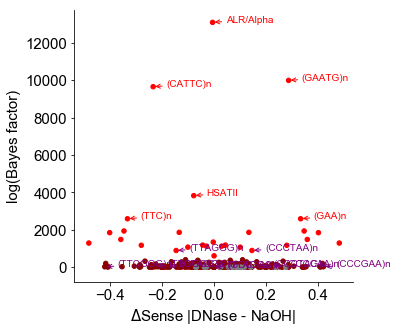

In [8]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111)
for lab, lab_df in  plot_bf_df.groupby('label'):
    alpha = 0.8
    color = 'gray' 
        
    data = []
    text = []
    colors = []
    for i, row in lab_df.iterrows():
        x = row[x_val]
        y = row[y_val]
        if (row[y_val] > 2000 or (row[y_val] > 0 and re.search(telo, row['gene_name']))): 
            color = row['color'] if not re.search(telo, row['gene_name']) else 'purple'
            text.append(row['gene_name'])
                
            ax.annotate(row['gene_name'].split(':')[1],
                    xy=(x, y), 
                    xycoords='data',
                    xytext=(x+0.05, y+1), 
                    textcoords='data',
                    color = color,
                    arrowprops=dict(arrowstyle="->",
                            color = color,
                            connectionstyle="arc3"))
    
    lab_df.plot.scatter(x_val, y_val, ax = ax, color = lab_df.color.tolist())#, alpha=alpha )
plt.axvline(x = 0, linestyle=':', alpha=0.01, color='gray')
sns.despine()
#ax.set_ylim(0,1000)
ax.set_ylabel('log(Bayes factor)')
ax.set_xlabel('$\Delta$Sense |DNase - NaOH|')
fig.savefig(figure_path + '/bayes_factor_satellite.png',bbox_inches ='tight')

In [9]:
plot_bf_df[plot_bf_df.gene_name.str.contains(telo+'|telo')]

variable,gene_name,gene_id,DNase: alpha1,DNase: antisense,DNase: average,DNase: beta1,DNase: eb_estimate,DNase: sense,NaOH: alpha1,NaOH: antisense,NaOH: average,NaOH: beta1,NaOH: eb_estimate,NaOH: sense,log_bf,pval,qval,delta_sense,label,color
300,Simple_repeats:(TTAGGG)n,Simple_repeats,246.329897,2016.0,0.107570,2019.310734,0.108724,243.0,1998.329897,5837.0,0.254724,5840.310734,0.254933,1995.0,895.695329,1.000000e+00,1.560153e+02,-0.146209,Antisense,red
143,Simple_repeats:(CCCTAA)n,Simple_repeats,2019.329897,243.0,0.892430,246.310734,0.891284,2016.0,5840.329897,1995.0,0.745276,1998.310734,0.745069,5837.0,895.691846,1.875524e-68,1.875524e-68,0.146215,Sense,red
316,Simple_repeats:(TTGGGG)n,Simple_repeats,27.329897,56.0,0.300000,59.310734,0.315440,24.0,348.329897,293.0,0.540752,296.310734,0.540347,345.0,57.337756,9.999887e-01,1.250153e+02,-0.224908,Antisense,darkred
132,Simple_repeats:(CCCCAA)n,Simple_repeats,59.329897,24.0,0.700000,27.310734,0.684781,56.0,296.329897,345.0,0.459248,348.310734,0.459682,293.0,57.335712,1.110700e-05,1.777707e-05,0.225099,Sense,darkred
192,Simple_repeats:(CTAGGG)n,Simple_repeats,20.329897,53.0,0.242857,56.310734,0.265263,17.0,1340.329897,1674.0,0.444039,1677.310734,0.444165,1337.0,44.802591,9.994505e-01,1.180160e+02,-0.178902,Antisense,darkred
144,Simple_repeats:(CCCTAG)n,Simple_repeats,56.329897,17.0,0.757143,20.310734,0.734987,53.0,1677.329897,1337.0,0.555961,1340.310734,0.555842,1674.0,44.802236,5.405882e-04,1.281237e-03,0.179146,Sense,darkred
310,Simple_repeats:(TTCGGG)n,Simple_repeats,3.329897,45.0,0.000000,48.310734,0.064482,0.0,51.329897,51.0,0.484848,54.310734,0.485892,48.0,23.582500,1.000000e+00,1.380153e+02,-0.421410,Antisense,darkred
140,Simple_repeats:(CCCGAA)n,Simple_repeats,48.329897,0.0,1.000000,3.310734,0.935889,45.0,54.329897,48.0,0.515152,51.310734,0.514290,51.0,23.570856,6.785411e-12,8.872719e-12,0.421599,Sense,darkred
224,Simple_repeats:(GCCTAA)n,Simple_repeats,5.329897,18.0,0.100000,21.310734,0.200066,2.0,5.329897,18.0,0.100000,21.310734,0.200066,2.0,7.141838,5.388423e-01,3.528203e+01,0.000000,Sense,darkred
299,Simple_repeats:(TTAGGC)n,Simple_repeats,21.329897,2.0,0.900000,5.310734,0.800653,18.0,21.329897,2.0,0.900000,5.310734,0.800653,18.0,7.136534,4.610119e-01,2.387173e+01,0.000000,Sense,darkred


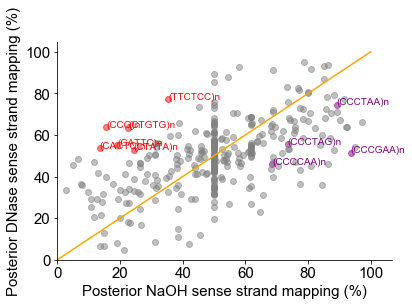

In [10]:
posterior_df['total'] =  posterior_df['DNase: antisense'] + posterior_df['DNase: sense']
posterior_df['x'] = posterior_df['DNase: eb_estimate'] * 100
posterior_df['y'] = posterior_df['NaOH: eb_estimate'] * 100

ax = plt.subplot(111)
for i, row in posterior_df.iterrows():
    if  ( row['y']/row['x'] > 2 and row['y'] > 50) or \
            (re.search(telo, row['gene_name']) and row['DNase: eb_estimate'] > row['NaOH: eb_estimate']):
        color = 'purple' if re.search(telo, row['gene_name']) else 'red'
        ax.text(row['x'],row['y'],
               row['gene_name'].replace('Simple_repeats:',''), 
                color=color,ha='left')
    else:
        color = 'grey'
        
    ax.scatter(row['x'], row['y'] , color = color, alpha=0.5)
ax.plot([0,100],[0,100], color = 'orange')
ax.set_ylabel('Posterior DNase sense strand mapping (%)')
ax.set_xlabel('Posterior NaOH sense strand mapping (%)')
ax.set_xlim(0,posterior_df['x'].max() * 1.1)
ax.set_ylim(0,posterior_df['y'].max() * 1.1)
#ax.set_xlim(0,1)
#ax.set_ylim(0,1)
sns.despine()

In [11]:
posterior_df.nlargest('delta_sense')

TypeError: nlargest() missing 1 required positional argument: 'columns'